# Flu Shot Learning - Machine Learning Final Project

In [ ]:
# Utilized data saved in google drive
from google.colab import drive
drive.mount('/content/drive')

In [3]:
from pathlib import Path

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Project data in google drive
#DATA_PATH = Path.cwd()/"drive"/"MyDrive"/"APC"/"data";
# Project data from repository
DATA_PATH = Path.cwd()/".."/"data";

features_train = pd.read_csv(
    DATA_PATH/"training_set_features.csv",
    index_col="respondent_id"
)

labels_train = pd.read_csv(
    DATA_PATH/"training_set_labels.csv",
    index_col="respondent_id"
)

np.testing.assert_array_equal(features_train.index.values, labels_train.index.values)

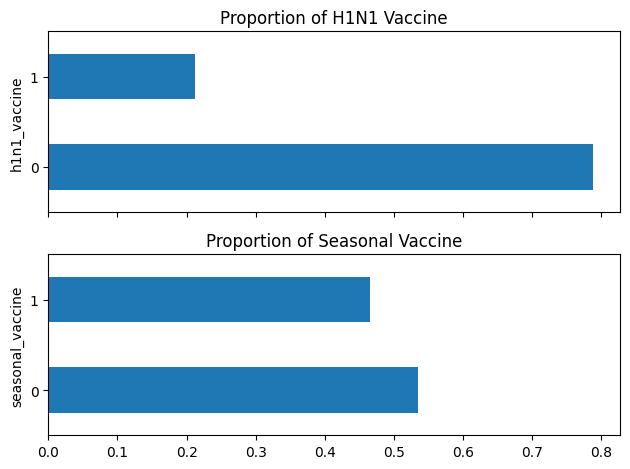

In [2]:
fig, ax = plt.subplots(2, 1, sharex=True)

n_obs = labels_train.shape[0]

(labels_train['h1n1_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of H1N1 Vaccine", ax=ax[0])
)
ax[0].set_ylabel("h1n1_vaccine")

(labels_train['seasonal_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of Seasonal Vaccine", ax=ax[1])
)
ax[1].set_ylabel("seasonal_vaccine")

fig.tight_layout()

For seasonal vaccines, the classes are pretty much balenced. But this is not the case for H1N1, where roughly 20% of people got the shot.

In [9]:
print("Correlation: "+ str((labels_train["h1n1_vaccine"]
     .corr(labels_train["seasonal_vaccine"], method="pearson")
)))

pd.crosstab(
    labels_train["h1n1_vaccine"], 
    labels_train["seasonal_vaccine"], 
    margins=True,
    normalize=True
)

Correlation: 0.37714265306144495


seasonal_vaccine,0,1,All
h1n1_vaccine,,,
0,0.497810,0.289737,0.787546
1,0.036582,0.175871,0.212454
All,0.534392,0.465608,1.000000


In [3]:
# Join both features and Labels in one matrix
joined_train = features_train.join(labels_train)
print(joined_train.shape)
joined_train.head()

(26707, 37)


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


#### Plotting several columns:

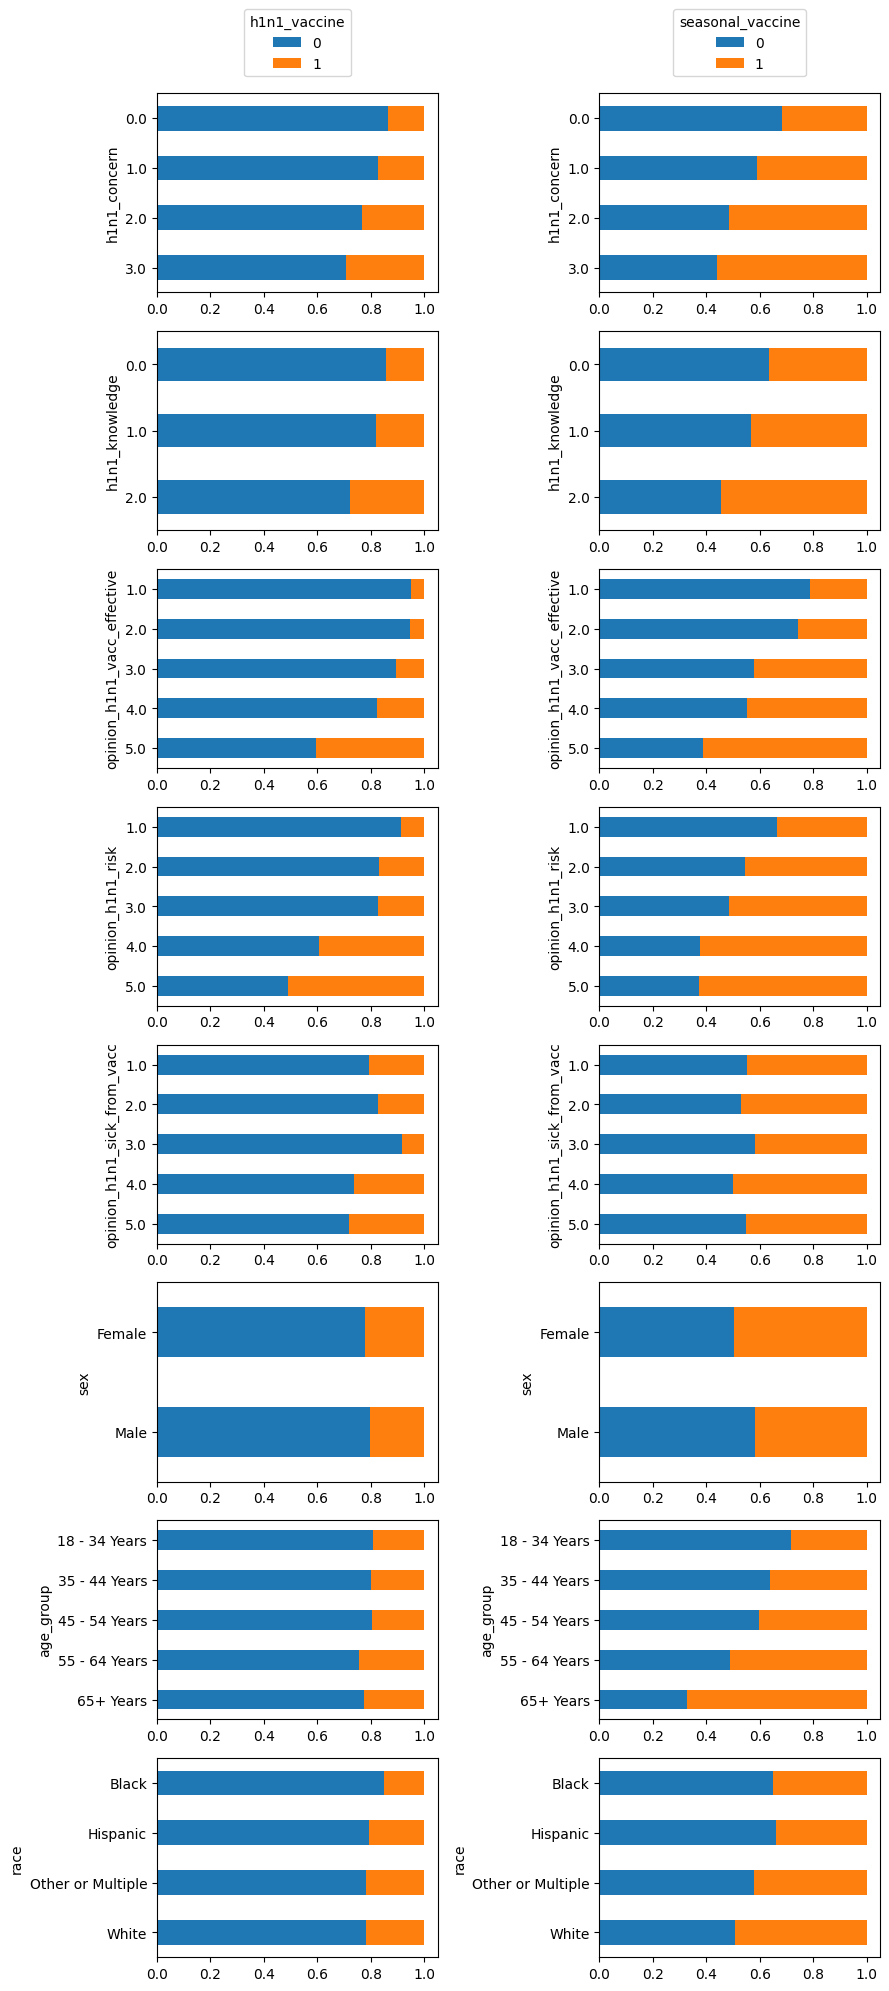

In [6]:
def vaccination_feature_plot(col, target, data, ax : plt.Axes = None):
    """This function will generate a stack bar chart of vaccination rate
    in proportion to a given feature"""
    counts = (joined_train[[target, col]]
                .groupby([target, col])
                .size()
                .unstack(target))
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()

cols= [
    'h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'sex', 'age_group', 'race'
]

fig, ax = plt.subplots(
    len(cols), 2, figsize =(9, len(cols)*2.5)
)

for i in range(len(cols)):
    vaccination_feature_plot(cols[i], 'h1n1_vaccine', joined_train, ax=ax[i, 0])
    vaccination_feature_plot(cols[i], 'seasonal_vaccine', joined_train, ax=ax[i, 1])

ax[0, 0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine')
ax[0, 1].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine')
fig.tight_layout()

### Prediction Models

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

from catboost import CatBoostClassifier

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

RANDOM_SEED = 1337 # Fixed random seed for reproducibility

Initially we'll experiment with a logistic regression model considering only the numerical features variables. For this it is required to apply some processing to the feature set:
- **Scaling**: Transform all features to be on the same scale.
- **NA Imputation**: Logistic regression does not handle NA values (i.e when survey respondents leave out answers unfilled). Median imputation will be utilized, which fills these missing values with the median from the training data.

*Note:* For non numerical categorical variables, one-hot encoding and ordinal encoding can be utilized

In [26]:
# Just the numerical features
numeric_col_index = features_train.columns[features_train.dtypes != "object"].values
# Categorical features
cat_col_index = features_train.columns[features_train.dtypes == 'object'].values

# Scaling and Imputation steps
numeric_preprocessing = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simpleImputer', SimpleImputer(strategy='median'))
])

categorical_preprocessing = Pipeline([
    #('Imputer', SimpleImputer(strategy='most_frequent')),
    ('Encoding', OneHotEncoder())
])

# Apply the preprocessing steps to a given feature column
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_preprocessing, numeric_col_index),
        ("categorical", categorical_preprocessing, cat_col_index),
    ], 
    #n_jobs=-1,
    remainder="drop"
)

estimators = MultiOutputClassifier(
    #estimator=LogisticRegression()
    estimator=LogisticRegression(penalty="l2", C=1, max_iter=1e6)
)

# FULL MODEL PIPELINE

full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators)
])
full_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('simpleImputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  array(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask',
       'behavioral_wash_hands', 'behavioral_large_gatherings',
       'b...
                                                 ('categorical',
                                                  Pipeline(steps=[('Encoding',
                                                                   OneHotEncoder())]),
                                                  array(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status',
       'hhs_geo_region', 'census_msa', 'employment_industry',
       'employment_occupation'], dtype=object))])),
                ('estimators',
                 MultiOutputClassifier(estimator=LogisticRegression(C=1,
                                                                    max_iter=1000000.0)))])

We've now got two possible estimation methods: one using a simple logistic regression, and another using cat boost.\
[Stackoverflow on how to use catboost cat_features with categorical preprocessing](https://stackoverflow.com/questions/56742441/how-to-track-categorical-indices-for-catboost-with-sklearn-pipeline)

#### Training and Evaluation

In [27]:
# Split the training data into two data sets, training and evaluation
X_train, X_eval, y_train, y_eval = train_test_split(
    features_train,
    labels_train,
    test_size=0.25, # 25% of data entries will be used for validation
    shuffle=True,
    stratify=labels_train,
    random_state=RANDOM_SEED
)

# Train the model
full_pipeline.fit(X_train, y_train)
# Evaluate
preds = full_pipeline.predict_proba(X_eval);

For the predictions, the pipeline has returned two arrays of predictions, one for each label `seasonal_vaccine` and `h1n1_vaccine`. Within each vector there are two classes, 0 and 1, so we'll only need the values of the second column (which correspond to the probability of having taken the vaccine)

In [28]:
y_preds = pd.DataFrame({
    "h1n1_vaccine": preds[0][:, 1],
    "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_eval.index
)
y_preds.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
8004,0.093321,0.920720
20429,0.150700,0.606097
6634,0.031541,0.021801
9580,0.924521,0.948754
20754,0.164424,0.436582


#### Performance Metrics (ROC)

For this competition, the performance of the model is measured by calculating the Area under the ROC (Receiver Operating Characteristic) curve through our model's output. The ROC is a graphical plot which illustrates the ability of our binary classifiers by plotting the rate of true positive classifications against the rate of false postives.

To then obtain a quantitative measurement of the performance, we can take the area beneath the curve. 

0.8457851380603585


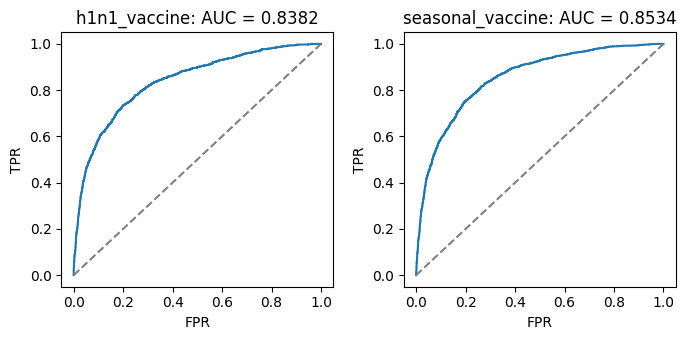

In [29]:
def plot_roc(y_true, y_score, label_name, ax : plt.Axes):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}")

fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine'], 'h1n1_vaccine', ax=ax[0])
plot_roc(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine'], 'seasonal_vaccine', ax=ax[1])
fig.tight_layout()

# Final score,
print(roc_auc_score(y_eval, y_preds))

### Generating predictions for the competition

In [25]:
def makeSubmissionCSV(pipeline : Pipeline, outputFilename):
    test_features = pd.read_csv(DATA_PATH / "test_set_features.csv", index_col="respondent_id")
    # Run the competition's test set to generate predictions
    test_probas = pipeline.predict_proba(test_features)

    submission = pd.read_csv(DATA_PATH / "submission_format.csv", index_col = "respondent_id")
    # Verify that the columns are in the right order
    np.testing.assert_array_equal(test_features.index.values,
        submission.index.values)

    # Select the probabilities a person has taken each vaccine
    submission["h1n1_vaccine"] = test_probas[0][:, 1]
    submission["seasonal_vaccine"] = test_probas[1][:, 1]

    submission.to_csv(Path.cwd() / ".." / "out" / outputFilename, index=True)

makeSubmissionCSV(full_pipeline, "submission.csv")